In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

import acquire
import prepare

In [2]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()

# SaaS Data using Parametric-Based Models

In [3]:
df = pd.read_csv("saas.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.sample(n=10)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
658507,2017-03-31,1022711,5658507,1.0,5.0
88784,2014-05-31,1010809,5088784,1.0,5.0
671761,2017-04-30,1020550,5671761,1.0,5.0
440847,2016-01-31,1014661,5440847,1.0,5.0
462923,2016-02-29,1023808,5462923,0.0,0.0
29095,2014-02-28,1009278,5029095,0.0,0.0
753034,2017-10-31,1011341,5753034,0.0,0.0
200195,2014-11-30,1010785,5200195,0.0,0.0
135723,2014-07-31,1021001,5135723,0.0,0.0
65236,2014-04-30,1006217,5065236,1.0,5.0


In [6]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [7]:
df.tail()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0
790457,2017-12-31,1029399,5790457,0.0,0.0


In [8]:
df["Month_Invoiced"] = pd.to_datetime(df.Month_Invoiced)

In [9]:
df = df.sort_values(by="Month_Invoiced").set_index("Month_Invoiced")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


In [11]:
aggregation = "sum"
train = df[:"2016"].Amount.resample("MS").agg(aggregation)
test = df["2017":].Amount.resample("MS").agg(aggregation)

In [12]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 36
Testing Observations: 12


In [13]:
pd.concat([train.head(3), train.tail(3)])

Month_Invoiced
2014-01-01    35850.0
2014-02-01    37190.0
2014-03-01    38295.0
2016-10-01    53190.0
2016-11-01    53375.0
2016-12-01    53320.0
Name: Amount, dtype: float64

In [14]:
pd.concat([test.head(3), test.tail(3)])

Month_Invoiced
2017-01-01    53395.0
2017-02-01    53440.0
2017-03-01    53480.0
2017-10-01    53850.0
2017-11-01    53860.0
2017-12-01    53805.0
Name: Amount, dtype: float64

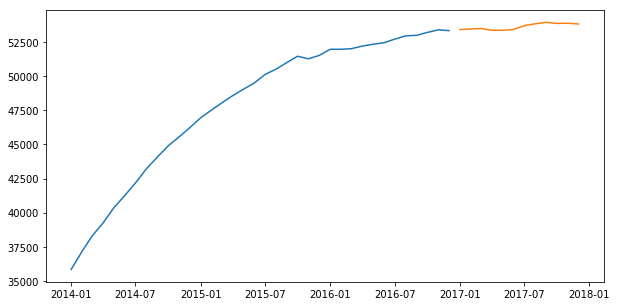

In [15]:
plt.figure(figsize=(10,5))
plt.plot(train)
plt.plot(test)
plt.show()

## Simple Average

In [16]:
yhat = pd.DataFrame(dict(actual=test))

In [17]:
yhat["simple_avg"] = train.mean()

In [18]:
yhat.head()

,actual,simple_avg
Month_Invoiced,,
2017-01-01,53395.0,47916.666667
2017-02-01,53440.0,47916.666667
2017-03-01,53480.0,47916.666667
2017-04-01,53350.0,47916.666667
2017-05-01,53340.0,47916.666667


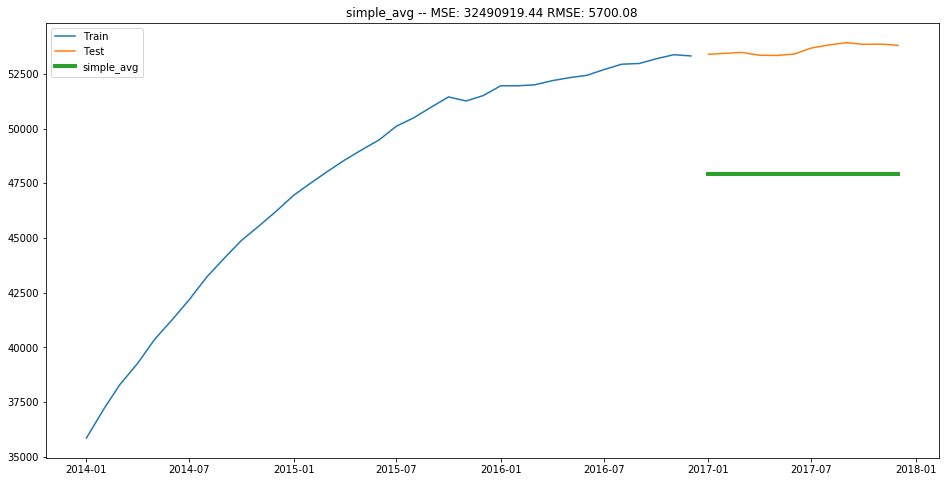

In [19]:
plot_and_eval(yhat.simple_avg, test)

## Moving Average

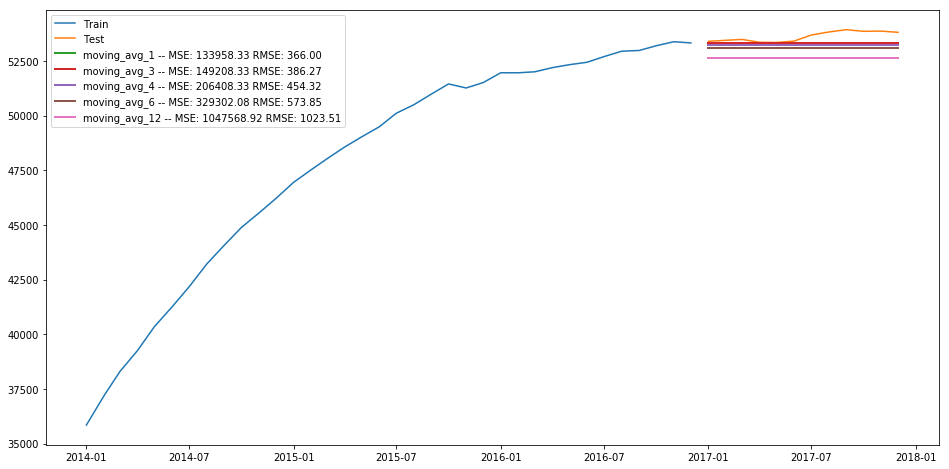

In [20]:
periods = [1, 3, 4, 6, 12]

for p in periods:
    yhat[f"moving_avg_{p}"] = train.rolling(p).mean().iloc[-1]

forecasts = [yhat[f"moving_avg_{p}"] for p in periods]
plot_and_eval(forecasts, test, linewidth=2)

## Holts Linear Trend

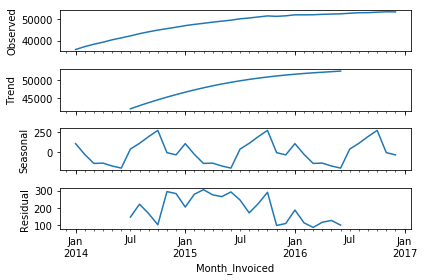

In [21]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [22]:
holt = Holt(train).fit(smoothing_level=.05, smoothing_slope=.05)
yhat["holt_linear"] = holt.forecast(test.shape[0])
yhat.fillna(yhat.holt_linear.mean(), inplace=True)
yhat.holt_linear.value_counts(dropna=False)

58040.846468    1
56671.088374    1
58954.018531    1
60780.362656    1
58497.432499    1
61236.948687    1
60323.776625    1
59867.190593    1
57127.674405    1
57584.260437    1
61693.534719    1
59410.604562    1
Name: holt_linear, dtype: int64

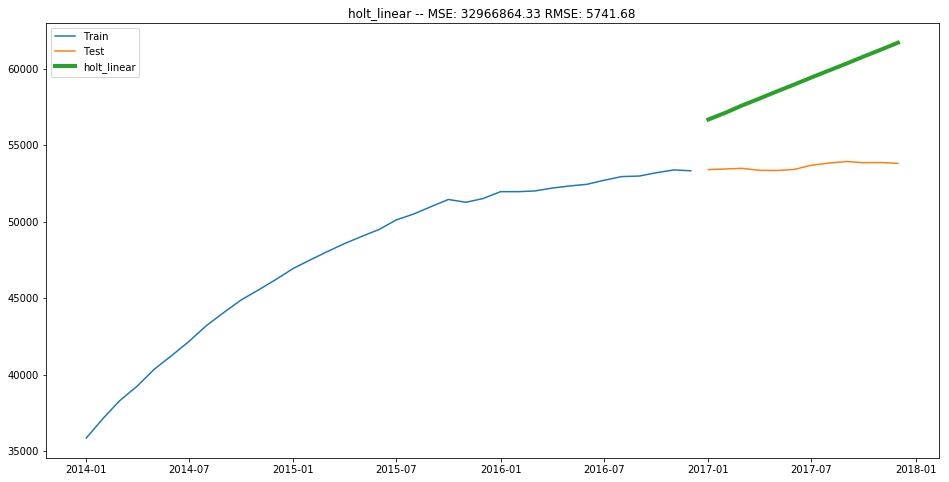

In [23]:
plot_and_eval(yhat.holt_linear, test)

In [24]:
train["2016"].head()

Month_Invoiced
2016-01-01    51955.0
2016-02-01    51955.0
2016-03-01    52000.0
2016-04-01    52190.0
2016-05-01    52325.0
Freq: MS, Name: Amount, dtype: float64

## Based on Last Year's Data

In [25]:
using_last_year = train["2016"].reindex(train["2016"].index + 12)

In [26]:
using_last_year = train["2016"]

In [27]:
train["2016"]

Month_Invoiced
2016-01-01    51955.0
2016-02-01    51955.0
2016-03-01    52000.0
2016-04-01    52190.0
2016-05-01    52325.0
2016-06-01    52435.0
2016-07-01    52695.0
2016-08-01    52940.0
2016-09-01    52975.0
2016-10-01    53190.0
2016-11-01    53375.0
2016-12-01    53320.0
Freq: MS, Name: Amount, dtype: float64

In [28]:
yhat["last_year"] = using_last_year.values

In [29]:
yhat.last_year

Month_Invoiced
2017-01-01    51955.0
2017-02-01    51955.0
2017-03-01    52000.0
2017-04-01    52190.0
2017-05-01    52325.0
2017-06-01    52435.0
2017-07-01    52695.0
2017-08-01    52940.0
2017-09-01    52975.0
2017-10-01    53190.0
2017-11-01    53375.0
2017-12-01    53320.0
Freq: MS, Name: last_year, dtype: float64

In [30]:
test

Month_Invoiced
2017-01-01    53395.0
2017-02-01    53440.0
2017-03-01    53480.0
2017-04-01    53350.0
2017-05-01    53340.0
2017-06-01    53405.0
2017-07-01    53680.0
2017-08-01    53820.0
2017-09-01    53925.0
2017-10-01    53850.0
2017-11-01    53860.0
2017-12-01    53805.0
Freq: MS, Name: Amount, dtype: float64

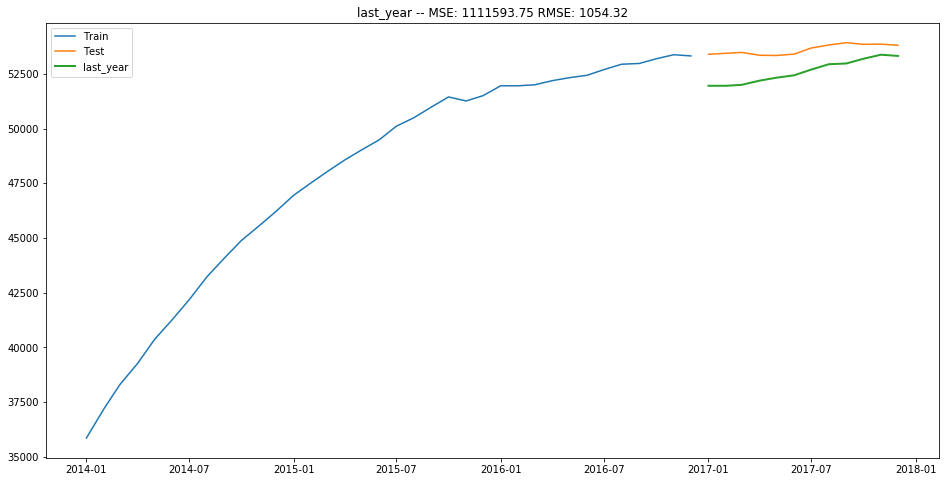

In [31]:
plot_and_eval(yhat.last_year, test, linewidth=2)

# Store Item Demand using Prophet

In [32]:
df = acquire.get_product_info()

Reading items.csv . . . .
Reading stores.csv . . . .
Reading sales.csv . . . .


In [33]:
df = prepare.prep_store_data(df)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 20 columns):
sale_quantity    913000 non-null float64
sale_id          913000 non-null int64
item_brand       913000 non-null object
item_id          913000 non-null int64
item_name        913000 non-null object
item_price       913000 non-null float64
item_upc12       913000 non-null int64
item_upc14       913000 non-null int64
store_address    913000 non-null object
store_city       913000 non-null object
store_id         913000 non-null int64
store_state      913000 non-null object
store_zipcode    913000 non-null int64
year             913000 non-null int64
quarter          913000 non-null int64
month            913000 non-null int64
day              913000 non-null int64
weekday          913000 non-null object
is_weekday       913000 non-null bool
sales_total      913000 non-null float64
dtypes: bool(1), float64(3), int64(10), object(6)
memory usage: 140.2+ MB


In [35]:
df_rice = df[df.item_brand == "Riceland"]

In [36]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18260 entries, 2013-01-01 to 2017-12-31
Data columns (total 20 columns):
sale_quantity    18260 non-null float64
sale_id          18260 non-null int64
item_brand       18260 non-null object
item_id          18260 non-null int64
item_name        18260 non-null object
item_price       18260 non-null float64
item_upc12       18260 non-null int64
item_upc14       18260 non-null int64
store_address    18260 non-null object
store_city       18260 non-null object
store_id         18260 non-null int64
store_state      18260 non-null object
store_zipcode    18260 non-null int64
year             18260 non-null int64
quarter          18260 non-null int64
month            18260 non-null int64
day              18260 non-null int64
weekday          18260 non-null object
is_weekday       18260 non-null bool
sales_total      18260 non-null float64
dtypes: bool(1), float64(3), int64(10), object(6)
memory usage: 2.8+ MB


In [37]:
df_rice["y"] = df_rice.sales_total

In [38]:
df_rice["ds"] = df_rice.index

In [39]:
df_rice = df_rice.groupby(["ds"])["y"].sum().reset_index()

In [40]:
df_rice.head()

,ds,y
0,2013-01-01 00:00:00+00:00,111.72
1,2013-01-02 00:00:00+00:00,83.16
2,2013-01-03 00:00:00+00:00,106.68
3,2013-01-04 00:00:00+00:00,121.80
4,2013-01-05 00:00:00+00:00,125.16


In [41]:
df_rice.ds.value_counts(dropna=False)

2016-11-14 00:00:00+00:00    1
2017-08-28 00:00:00+00:00    1
2016-12-11 00:00:00+00:00    1
2016-04-07 00:00:00+00:00    1
2017-05-29 00:00:00+00:00    1
2015-11-17 00:00:00+00:00    1
2014-08-11 00:00:00+00:00    1
2016-04-13 00:00:00+00:00    1
2013-04-21 00:00:00+00:00    1
2015-08-03 00:00:00+00:00    1
2015-08-12 00:00:00+00:00    1
2015-03-08 00:00:00+00:00    1
2014-11-28 00:00:00+00:00    1
2017-03-11 00:00:00+00:00    1
2017-05-25 00:00:00+00:00    1
2015-05-16 00:00:00+00:00    1
2016-07-06 00:00:00+00:00    1
2016-03-27 00:00:00+00:00    1
2015-11-01 00:00:00+00:00    1
2016-12-22 00:00:00+00:00    1
2017-06-21 00:00:00+00:00    1
2014-02-06 00:00:00+00:00    1
2016-06-03 00:00:00+00:00    1
2016-04-18 00:00:00+00:00    1
2017-06-09 00:00:00+00:00    1
2015-09-03 00:00:00+00:00    1
2016-05-10 00:00:00+00:00    1
2015-10-21 00:00:00+00:00    1
2016-03-02 00:00:00+00:00    1
2013-07-22 00:00:00+00:00    1
                            ..
2015-12-06 00:00:00+00:00    1
2013-06-

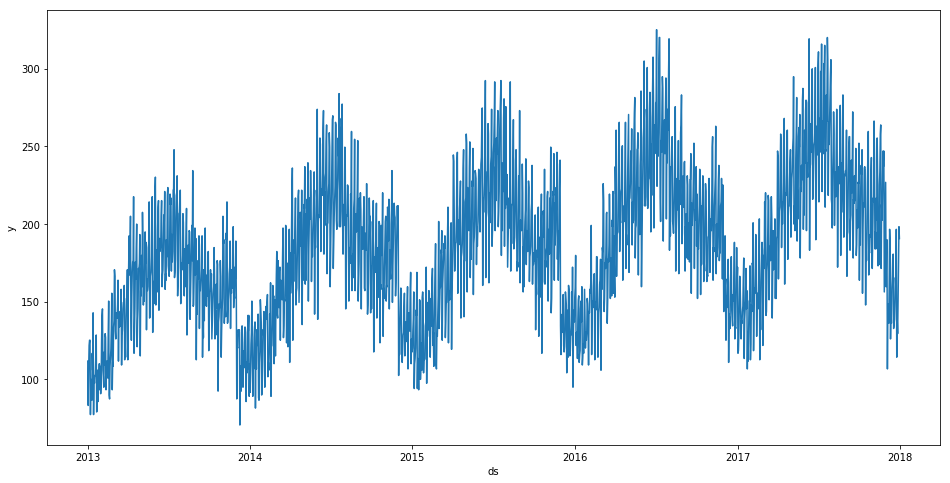

In [42]:
plt.figure(figsize=(16,8))
sns.lineplot(df_rice.ds, df_rice.y)

In [43]:
df_rice["ds"] = df_rice.ds.dt.tz_localize(None)

In [44]:
m = Prophet(daily_seasonality=True)
m.fit(df_rice)

In [45]:
future = m.make_future_dataframe(periods=365)

In [46]:
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [47]:
future.tail()

,ds
2186,2018-12-27
2187,2018-12-28
2188,2018-12-29
2189,2018-12-30
2190,2018-12-31


In [48]:
forecast = m.predict(future)

In [49]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
2186,2018-12-27,165.348796,145.563883,186.256454
2187,2018-12-28,178.655464,157.223744,199.741623
2188,2018-12-29,191.267852,171.385474,212.330505
2189,2018-12-30,202.282090,179.645597,221.791693
2190,2018-12-31,130.155925,107.579102,149.301844


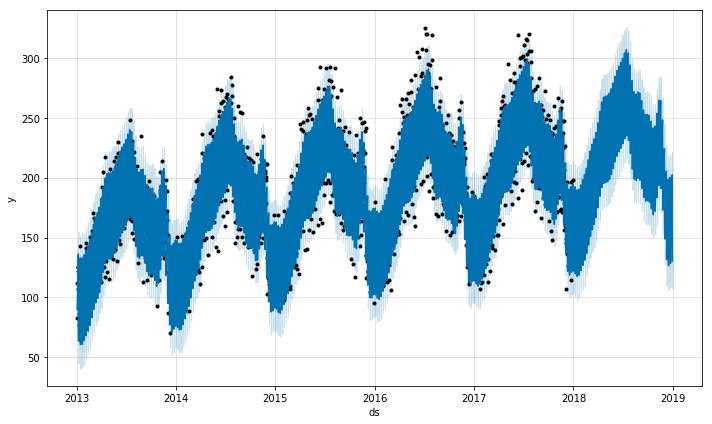

In [50]:
fig1 = m.plot(forecast)

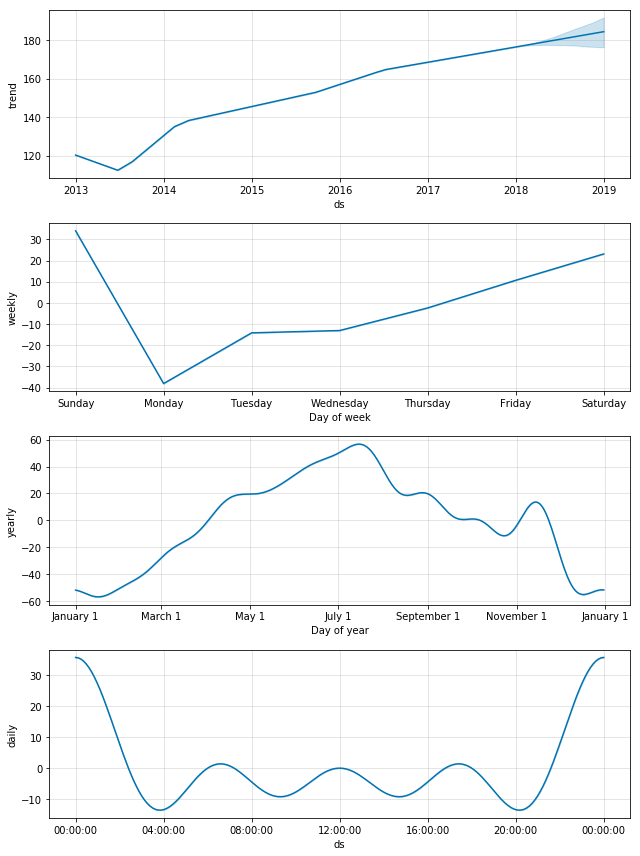

In [51]:
fig2 = m.plot_components(forecast)

In [52]:
df_cv = cross_validation(m, horizon="90 days")

INFO:fbprophet:Making 33 forecasts with cutoffs between 2013-10-23 00:00:00 and 2017-10-02 00:00:00


In [53]:
df_p = performance_metrics(df_cv)

In [54]:
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
278,9 days,294.543487,17.162269,13.801352,0.077485,0.686869
1899,10 days,294.720711,17.167432,13.815960,0.077503,0.686869
369,10 days,295.368455,17.186287,13.843780,0.077652,0.686869
639,10 days,292.921698,17.114955,13.762349,0.077008,0.690236
729,10 days,291.498868,17.073338,13.701931,0.076796,0.693603


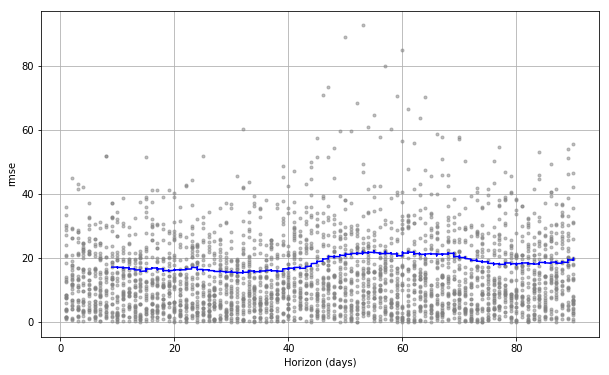

In [55]:
fig3 = plot_cross_validation_metric(df_cv, metric="rmse")